# Library Import

In [1]:
print('hello')

hello


In [2]:
import numpy as np
import pandas as pd 
import os

import matplotlib.pyplot as plt 

In [3]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Recommended for full determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
GPU Name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))


# Data Load 


In [8]:
train_dir = '/home/abhishek/GitHub_Projects/metal-surface-defect-classification/data/raw/train'
print("Train Direcorty: ",os.listdir(train_dir))
test_dir = '/home/abhishek/GitHub_Projects/metal-surface-defect-classification/data/raw/test'
print("test Direcorty: ",os.listdir(test_dir))
val_dir = '/home/abhishek/GitHub_Projects/metal-surface-defect-classification/data/raw/valid'
print("val Direcorty: ",os.listdir(val_dir))

Train Direcorty:  ['Crazing', 'Patches', 'Inclusion', 'Scratches', 'Pitted', 'Rolled']
test Direcorty:  ['Crazing', 'Patches', 'Inclusion', 'Scratches', 'Pitted', 'Rolled']
val Direcorty:  ['Crazing', 'Patches', 'Inclusion', 'Scratches', 'Pitted', 'Rolled']


# Custom Data Loader

In [9]:
import os
from torch.utils.data import Dataset
from PIL import Image

class MetalSurfaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir -> path to the train folder
        train/ 
            Crazing/
            Inclusion/
            ...
        """

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {} # mapping class names to integers

        # Step 1 : Create class index mapping
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Step 2 : iterate through each class folder
        for cls_name in classes:
            cls_folder = os.path.join(root_dir,cls_name)
            label = self.class_to_idx[cls_name]

            # Step 3 : Iterate thrugh each image in one class folder
            for file_name in sorted(os.listdir(cls_folder)):
                file_path = os.path.join(cls_folder, file_name)
                
                # Append image path and corresponding label
                self.image_paths.append(file_path)
                self.labels.append(label)
     
    def __len__(self):
        """ Return total count of images. """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Getting a sample image 
        """
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Apply transforms (resize, normalize, etc.)
        if self.transform:
            img = self.transform(img)

        return img, label

## Defining Data Pre-processing

In [10]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean= [0.485,0.456, 0.406],
        std= [0.229,0.224,0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [11]:
train_dataset = MetalSurfaceDataset(
    root_dir= train_dir,
    transform= train_transform
)

val_dataset = MetalSurfaceDataset(
    root_dir= val_dir,
    transform= val_transform
)

test_dataset = MetalSurfaceDataset(
    root_dir= test_dir,
    transform= test_transform
)

In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size= 32,
    shuffle= True,
    num_workers= 2,
    pin_memory= True
)

val_loader = DataLoader(
    val_dataset,
    batch_size= 32,
    shuffle= False,
    num_workers= 2,
    pin_memory= True
)

test_loader = DataLoader(
    test_dataset,
    batch_size= 32,
    shuffle= False,
    num_workers= 2,
    pin_memory= True
)

In [13]:
print(f"Total Number of Train Images : {train_dataset.__len__()}")
print(f"Total Number of Validation Images : {val_dataset.__len__()}")
print(f"Total Number of Test Images : {test_dataset.__len__()}")

Total Number of Train Images : 1656
Total Number of Validation Images : 72
Total Number of Test Images : 72


# Data Visualization

In [14]:
def show_tensor_image(tensor, title=""):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    img = tensor * std[:, None, None] + mean[:, None, None]
    img = img.permute(1, 2, 0).clamp(0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

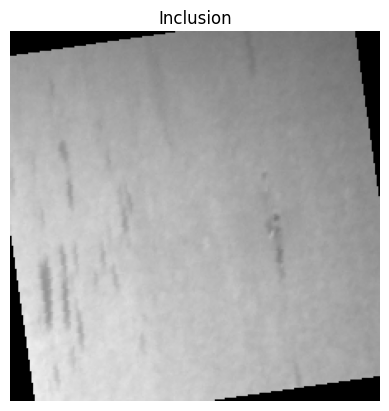

In [15]:
sample_number = 400

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

image, label = train_dataset.__getitem__(sample_number)

show_tensor_image(image, idx_to_class[label])

# Model Definition

In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class MyResNet18(nn.Module):
    def __init__(self, num_classes= 6, freeze_backbone= True):
        super().__init__()

        # Load pretrained Resnet18
        self.model = models.resnet18(weights= models.ResNet18_Weights)

        # Freeze the backbone if needed
        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False

        # Replace the classifier
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    
    def forward(self, x):
        return self.model(x)

In [17]:
from torchsummary import summary

temp_model = MyResNet18(num_classes= 6).to(device)
summary(temp_model, input_size= (3,224,224))

/home/abhishek/GitHub_Projects/metal-surface-defect-classification/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/abhishek/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:20<00:00, 2.27MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
trainable_params = sum(p.numel() for p in temp_model.parameters() if p.requires_grad)

# FC layer params = in_features * num_classes + bias
expected = temp_model.fc.in_features * 6 + 6

assert trainable_params == expected, "Trainable parameter count mismatch."

AttributeError: 'MyResNet18' object has no attribute 'fc'

# Model Training

In [19]:
import torch.optim as optim
from tqdm import tqdm

In [29]:
model = MyResNet18(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [30]:
num_epochs = 10

best_val_acc = 0
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses_list = []
val_losses_list = []
train_accs_list = []
val_accs_list = []

for epoch in range(num_epochs):

    # --------------------
    # TRAINING
    # --------------------
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_loss / len(train_dataset)
    train_epoch_acc  = train_correct / train_total


    # --------------------
    # VALIDATION
    # --------------------
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc  = val_correct / val_total

    # Save logs
    train_losses_list.append(train_epoch_loss)
    val_losses_list.append(val_epoch_loss)
    train_accs_list.append(train_epoch_acc)
    val_accs_list.append(val_epoch_acc)

    print("----------------------------------------------------------------------------------------------------")
    # Print Summary
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")


    # --------------------
    # CHECKPOINT (based on val accuracy)
    # --------------------
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), "/home/abhishek/GitHub_Projects/metal-surface-defect-classification/models/best_resnet18.pth")
        print("✔ Saved Best Model")

    # --------------------
    # EARLY STOPPING (based on val loss)
    # --------------------
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement in val_loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print("🔥 Early stopping triggered!")
            break

    scheduler.step()

    print("----------------------------------------------------------------------------------------------------")


Epoch 1/10: 100%|██████████| 52/52 [00:05<00:00,  8.73it/s]


----------------------------------------------------------------------------------------------------
Epoch [1/10] | Train Loss: 0.9795 | Train Acc: 0.7464 | Val Loss: 0.4950 | Val Acc: 0.9444
✔ Saved Best Model
----------------------------------------------------------------------------------------------------


Epoch 2/10: 100%|██████████| 52/52 [00:05<00:00,  9.25it/s]


----------------------------------------------------------------------------------------------------
Epoch [2/10] | Train Loss: 0.3591 | Train Acc: 0.9426 | Val Loss: 0.1470 | Val Acc: 1.0000
✔ Saved Best Model
----------------------------------------------------------------------------------------------------


Epoch 3/10: 100%|██████████| 52/52 [00:05<00:00,  9.22it/s]


----------------------------------------------------------------------------------------------------
Epoch [3/10] | Train Loss: 0.2294 | Train Acc: 0.9607 | Val Loss: 0.0986 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 4/10: 100%|██████████| 52/52 [00:05<00:00,  8.91it/s]


----------------------------------------------------------------------------------------------------
Epoch [4/10] | Train Loss: 0.1879 | Train Acc: 0.9601 | Val Loss: 0.0633 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 5/10: 100%|██████████| 52/52 [00:06<00:00,  8.02it/s]


----------------------------------------------------------------------------------------------------
Epoch [5/10] | Train Loss: 0.1560 | Train Acc: 0.9680 | Val Loss: 0.0399 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 6/10: 100%|██████████| 52/52 [00:05<00:00,  8.67it/s]


----------------------------------------------------------------------------------------------------
Epoch [6/10] | Train Loss: 0.1371 | Train Acc: 0.9740 | Val Loss: 0.0394 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 7/10: 100%|██████████| 52/52 [00:06<00:00,  8.09it/s]


----------------------------------------------------------------------------------------------------
Epoch [7/10] | Train Loss: 0.1225 | Train Acc: 0.9825 | Val Loss: 0.0388 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 8/10: 100%|██████████| 52/52 [00:06<00:00,  8.22it/s]


----------------------------------------------------------------------------------------------------
Epoch [8/10] | Train Loss: 0.1265 | Train Acc: 0.9752 | Val Loss: 0.0363 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 9/10: 100%|██████████| 52/52 [00:06<00:00,  8.58it/s]


----------------------------------------------------------------------------------------------------
Epoch [9/10] | Train Loss: 0.1323 | Train Acc: 0.9710 | Val Loss: 0.0393 | Val Acc: 1.0000
No improvement in val_loss for 1 epochs.
----------------------------------------------------------------------------------------------------


Epoch 10/10: 100%|██████████| 52/52 [00:06<00:00,  8.01it/s]


----------------------------------------------------------------------------------------------------
Epoch [10/10] | Train Loss: 0.1172 | Train Acc: 0.9807 | Val Loss: 0.0367 | Val Acc: 1.0000
No improvement in val_loss for 2 epochs.
----------------------------------------------------------------------------------------------------


In [27]:
import torch
import time

x = torch.randn(10000, 10000, device="cuda")
torch.cuda.synchronize()
t0 = time.time()
y = x @ x
torch.cuda.synchronize()
print("Time:", time.time() - t0)

Time: 0.6087889671325684


## Model Performance Tracking

In [20]:
num_epochs

10

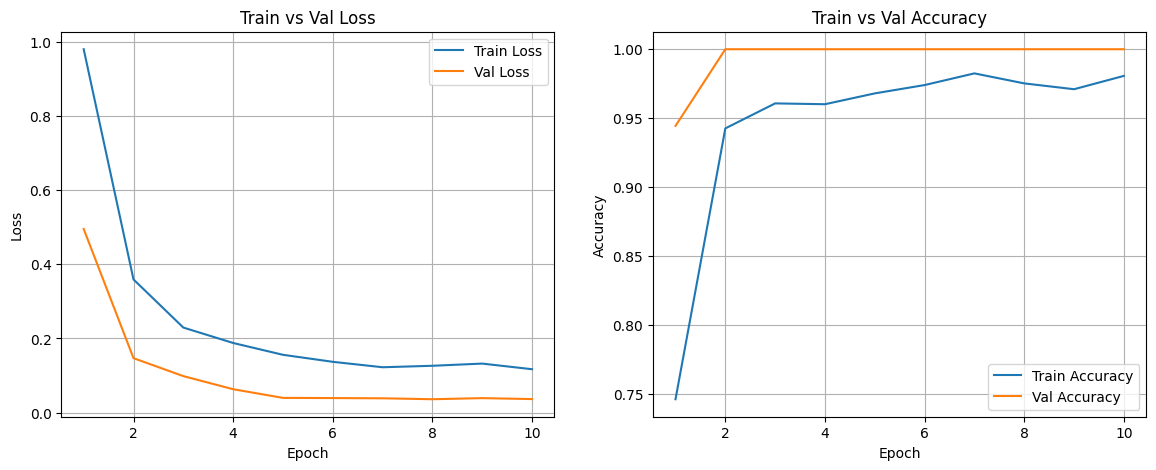

In [31]:
from matplotlib import pyplot as plt

epochs = range(1, epoch + 2)

plt.figure(figsize=(14,5))

# ---- Plot Loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_list, label="Train Loss")
plt.plot(epochs, val_losses_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

# ---- Plot Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_list, label="Train Accuracy")
plt.plot(epochs, val_accs_list, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.show()

# Model Evaluation

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [ ]:
final_model_path = "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/models/best_resnet18.pth"

In [24]:
from torchvision import models

model = MyResNet18(num_classes= 6)

model.load_state_dict(torch.load(final_model_path, weights_only= True))
model = model.to(device)
model.eval(); # Set to inference mode

d:\Coding Projects\GitHub Projects\metal-surface-defect-classification\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Images covered: 72
Total test images: 72
Test Accuracy : 98.61 %


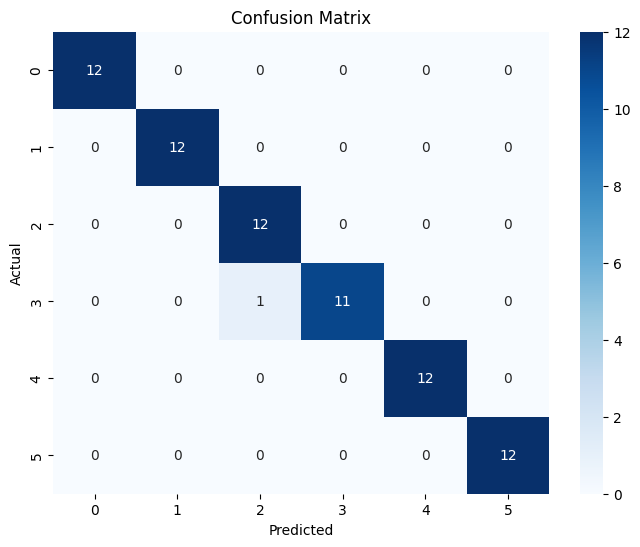

In [25]:
all_preds = []
all_labels = []

correct = 0
total = 0

total_image_count = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        total_image_count += len(labels)

        # print(images.shape)
        # print(labels.shape)

        outputs = model(images)
        _, predicted = outputs.max(1)

        # Accuracy Tracting 
        correct += (predicted ==  labels).sum().item()
        total += labels.size(0)

        # Store for Confusion Matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Printing total image count
print("Images covered:", total_image_count)
print("Total test images:", len(test_dataset))

# Final Accuracy

test_acc = correct / total
print(f"Test Accuracy : {100*test_acc:.2f} %")

# Confusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.class_to_idx.keys()))

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       0.92      1.00      0.96        12
      Pitted       1.00      0.92      0.96        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



In [36]:
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/abhishek/GitHub_Projects/metal-surface-defect-classification/env/lib/python3.10/site-packages',
 '/tmp/tmptz2bkj_t',
 '/home/abhishek/GitHub_Projects']

In [35]:
from src.config import Config

cfg = Config()
print(cfg)

ModuleNotFoundError: No module named 'src'

In [28]:
from pathlib import Path


class Config:
    # Paths
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
    DATA_ROOT = PROJECT_ROOT / "data"

    TRAIN_DIR = DATA_ROOT / "train"
    VAL_DIR = DATA_ROOT / "val"
    TEST_DIR = DATA_ROOT / "test"

    # Image / dataloader config
    IMG_SIZE = 224
    BATCH_SIZE = 32
    NUM_WORKERS = 0  # tune based on your CPU
    PIN_MEMORY = True  # good if using GPU

    # Classification related
    NUM_CLASSES = 6  # change to your actual number


NameError: name '__file__' is not defined

In [ ]:
D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/references

In [9]:
from src.config import Config
from src.data.dataset import get_dataloaders

cfg = Config("configs/data.yaml")

FileNotFoundError: [Errno 2] No such file or directory: 'configs/data.yaml'

In [4]:
cfg.train_dir

'data/raw/train'

In [10]:
from pathlib import Path
import os
import yaml

class Config:
    PROJECT_ROOT = Path(__file__).resolve().parent[2] # Go up two folders to the project root folder

    def __init__(self, config_path: str):

        config_path = self.PROJECT_ROOT / config_path

        with open(config_path, "r") as f:
            cfg = yaml.safe_load(f)

        data_cfg = cfg["data"]

        self.train_dir = data_cfg["train_dir"]
        self.val_dir = data_cfg["val_dir"]
        self.test_dir = data_cfg["test_dir"]
        
        self.batch_size = data_cfg["batch_size"]
        self.num_workers = data_cfg["num_workers"]

NameError: name '__file__' is not defined

In [ ]:
import yaml

config_path = "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/configs/config.yaml"

with open(config_path, "r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)

In [36]:
cfg.keys()

dict_keys(['data', 'model', 'train'])

In [37]:
cfg["data"]["batch_size"]

32

In [12]:
from src.config import Config

# src\config.py
    
cfg = Config()

# cfg.

ModuleNotFoundError: No module named 'src'

In [10]:
cfg.data

AttributeError: 'Config' object has no attribute 'data'

In [ ]:
def get_test_data_loaders(test_dir, batch_size=32, num_workers=0):
    """
    Function to get the data loader for test dataset
    
    :param test_dir: test directory location
    :param batch_size: batch size to be kept for the data loaders
    :param num_workers: number of workers to be kept for the data loaders

    Returns :
        test 
        And Class_Name to index mapping dictionery

    """

    test_ds = MetalSurfaceDataset(test_dir, transform=test_transform)

    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)

    return test_loader, len(test_ds) , test_ds.class_to_idx

In [ ]:
(test_loader, dataset_length, class_to_idx) = get_test_data_loaders(
    test_dir= cfg.data["test_dir"],
    batch_size= cfg.data["batch_size"],
    num_workers= cfg.data["num_workers"],
)

print(dataset_length)

In [ ]:
def test_valid_one_epoch():
    """
    test one poch of the valid function 
    """
    model = create_model()
    optimizer = optim.Adam(model.parameters(), lr= cfg.valid['lr'])
    criterion = nn.CrossEntropyLoss()

    # create a dummy dataloader
    x = torch.randn(4, 3, 224, 224)
    y = torch.randint(0, 6, (4,))
    dataset = TensorDataset(x, y)
    loader = DataLoader(dataset, batch_size=2)


    (valid_epoch_loss, valid_epoch_acc) = valid_one_epoch(
        model= model,
        valid_loader= loader,
        optimizer= optimizer,
        criterion= criterion,
        valid_dataset_length= len(dataset),
        epoch= 1,
        num_epochs= 1,
        device= device,
    )

    assert isinstance(valid_epoch_loss, float) , "valid epoch Loss is not a float"

    assert isinstance(valid_epoch_acc, float) , "valid epoch Acc is not a float"

In [12]:
(633 + 276) / (800 + 300)

0.8263636363636364

In [9]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y_%m_%d")
type(timestamp)

str

In [15]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve().parent   # or manually point to your project root
sys.path.append(str(ROOT))

print("Added to PATH:", ROOT)


Added to PATH: D:\Coding Projects\GitHub Projects\metal-surface-defect-classification


In [17]:
from src.config import Config

cfg = Config()

In [23]:
cfg.train["checkpoint_path"].split('.')[0] + "_" + datetime.now().strftime("%Y_%m_%d") + ".pth"

'models/resnet18_best_2025_12_11.pth'